# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2020-10-28

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-10-28.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 109 to 84152
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      230 non-null    datetime64[ns]
 1   Day                 230 non-null    object        
 2   Week                230 non-null    int64         
 3   Daily_delta         230 non-null    int64         
 4   Total_reported      230 non-null    int64         
 5   Deceased            230 non-null    int64         
 6   Deceased_delta      230 non-null    int64         
 7   Hospital_admission  230 non-null    int64         
 8   Hospital_delta      230 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 18.0+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
80849,2020-10-19,Monday,43,533,22931,313,1,915,14
81216,2020-10-20,Tuesday,43,696,23627,313,0,918,3
81583,2020-10-21,Wednesday,43,751,24378,313,0,925,7
81950,2020-10-22,Thursday,43,813,25191,313,0,939,14
82317,2020-10-23,Friday,43,745,25936,314,1,953,14
82684,2020-10-24,Saturday,43,506,26442,319,5,966,13
83051,2020-10-25,Sunday,43,831,27273,319,0,974,8
83418,2020-10-26,Monday,44,526,27799,324,5,988,14
83785,2020-10-27,Tuesday,44,686,28485,328,4,994,6
84152,2020-10-28,Wednesday,44,348,28833,337,9,1000,6


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
83051,2020-10-25,43,831,27273,8
81950,2020-10-22,43,813,25191,14
81583,2020-10-21,43,751,24378,7
82317,2020-10-23,43,745,25936,14
78647,2020-10-13,42,734,19163,16
80482,2020-10-18,42,726,22398,7
81216,2020-10-20,43,696,23627,3
80115,2020-10-17,42,687,21672,19
83785,2020-10-27,44,686,28485,6
79748,2020-10-16,42,682,20985,7


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

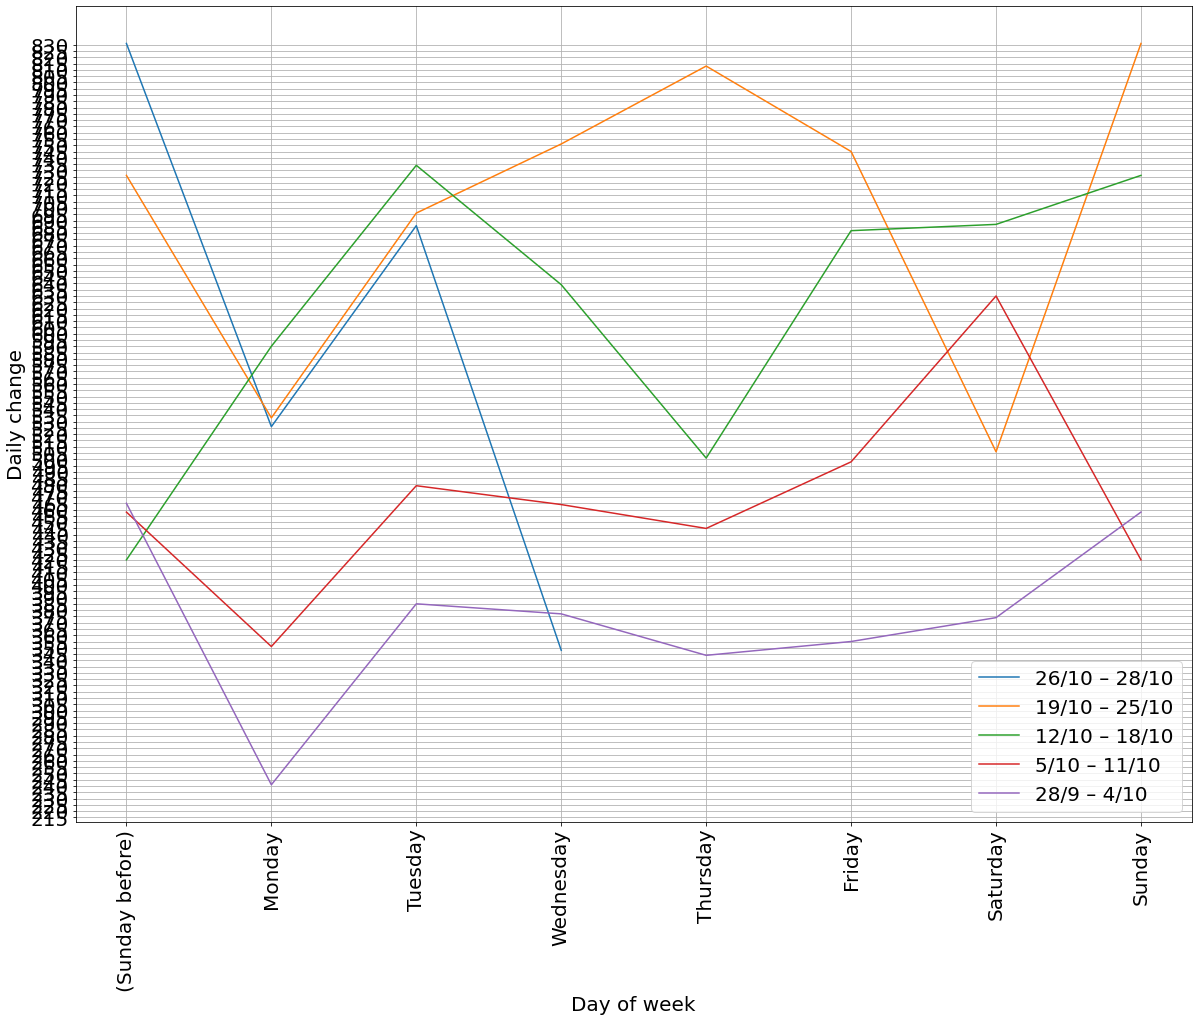

,Date_of_report,Week,Daily_delta,Total_reported
81950,2020-10-22,43,813,25191
82317,2020-10-23,43,745,25936
82684,2020-10-24,43,506,26442
83051,2020-10-25,43,831,27273
83418,2020-10-26,44,526,27799
83785,2020-10-27,44,686,28485
84152,2020-10-28,44,348,28833


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

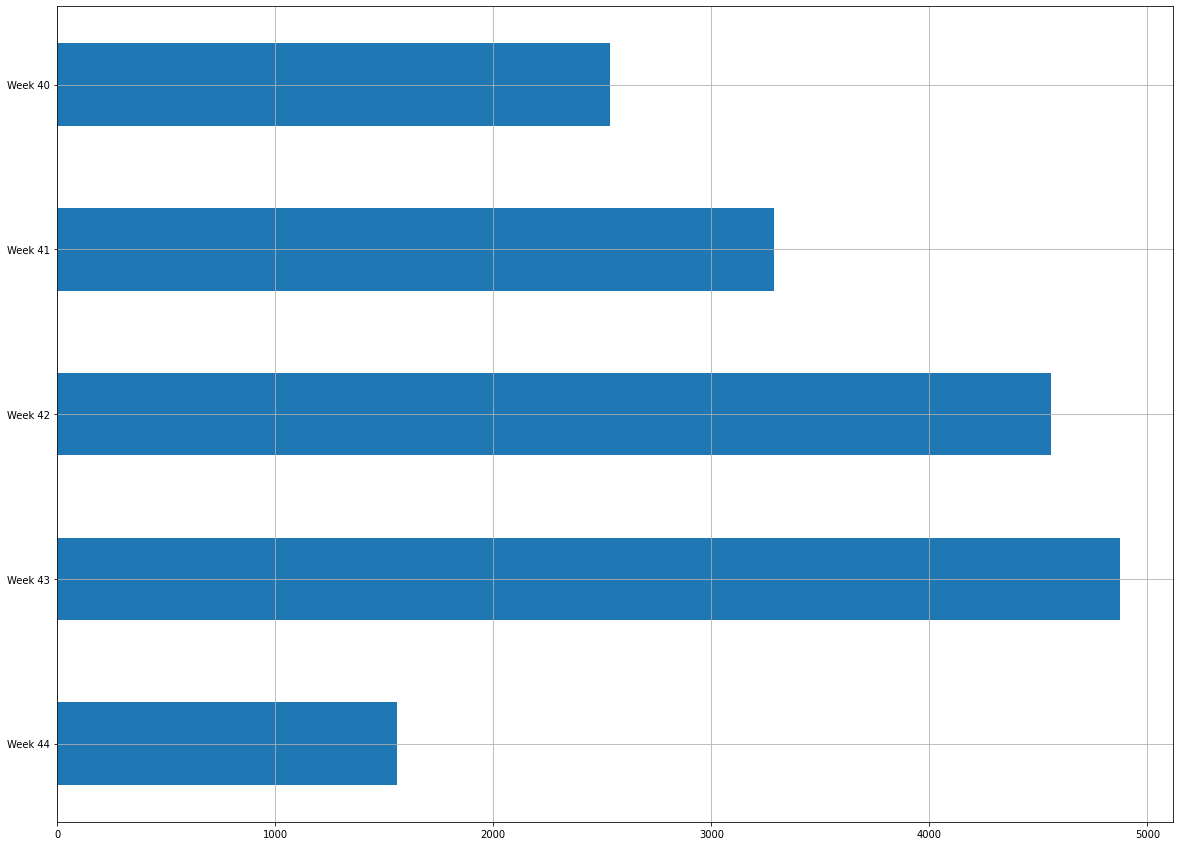

{'Week 40': 2534,
 'Week 41': 3287,
 'Week 42': 4559,
 'Week 43': 4875,
 'Week 44': 1560}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

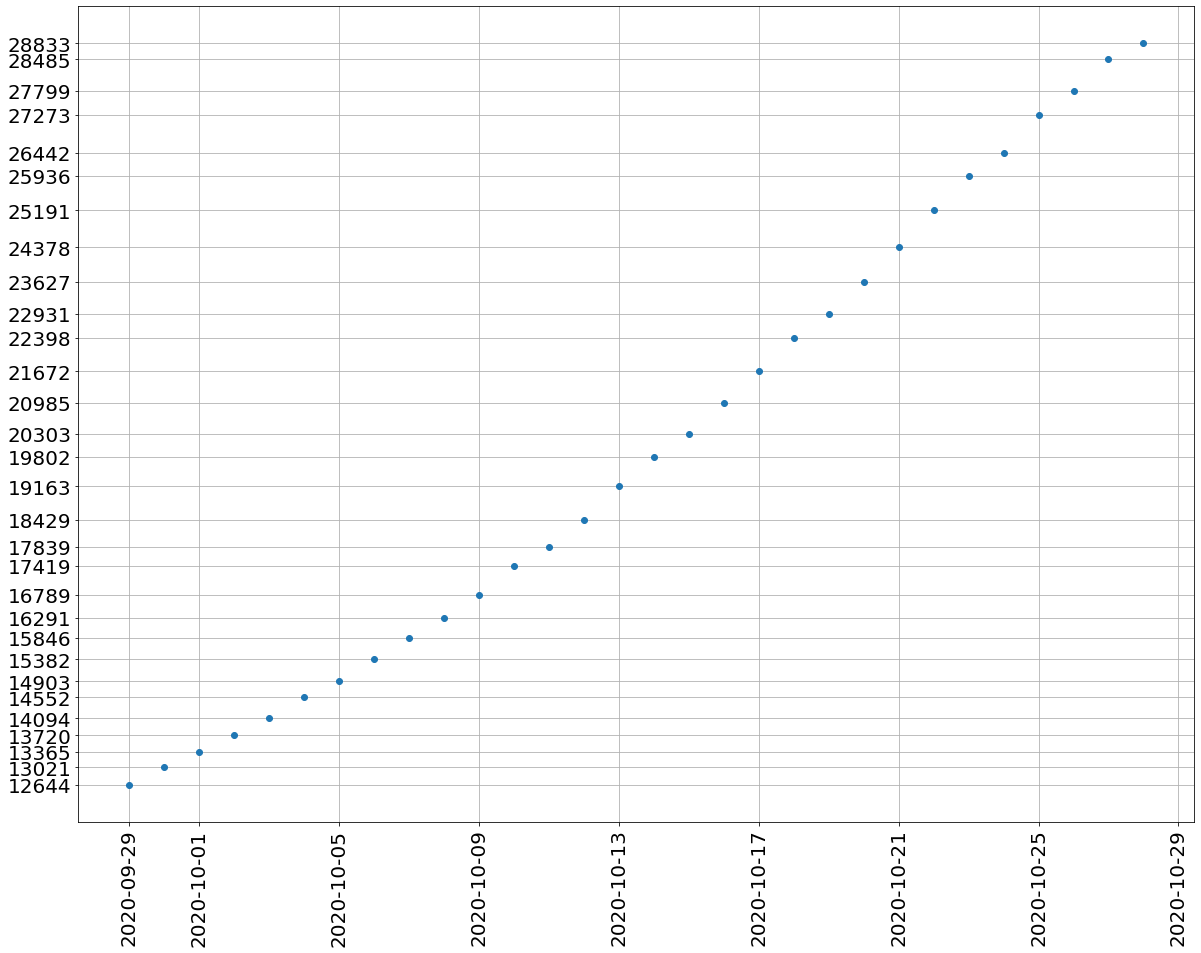

      Date_of_report  Total_reported
73509     2020-09-29           12644
73876     2020-09-30           13021
74243     2020-10-01           13365
74610     2020-10-02           13720
74977     2020-10-03           14094
75344     2020-10-04           14552
75711     2020-10-05           14903
76078     2020-10-06           15382
76445     2020-10-07           15846
76812     2020-10-08           16291
77179     2020-10-09           16789
77546     2020-10-10           17419
77913     2020-10-11           17839
78280     2020-10-12           18429
78647     2020-10-13           19163
79014     2020-10-14           19802
79381     2020-10-15           20303
79748     2020-10-16           20985
80115     2020-10-17           21672
80482     2020-10-18           22398
80849     2020-10-19           22931
81216     2020-10-20           23627
81583     2020-10-21           24378
81950     2020-10-22           25191
82317     2020-10-23           25936
82684     2020-10-24           26442
8

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

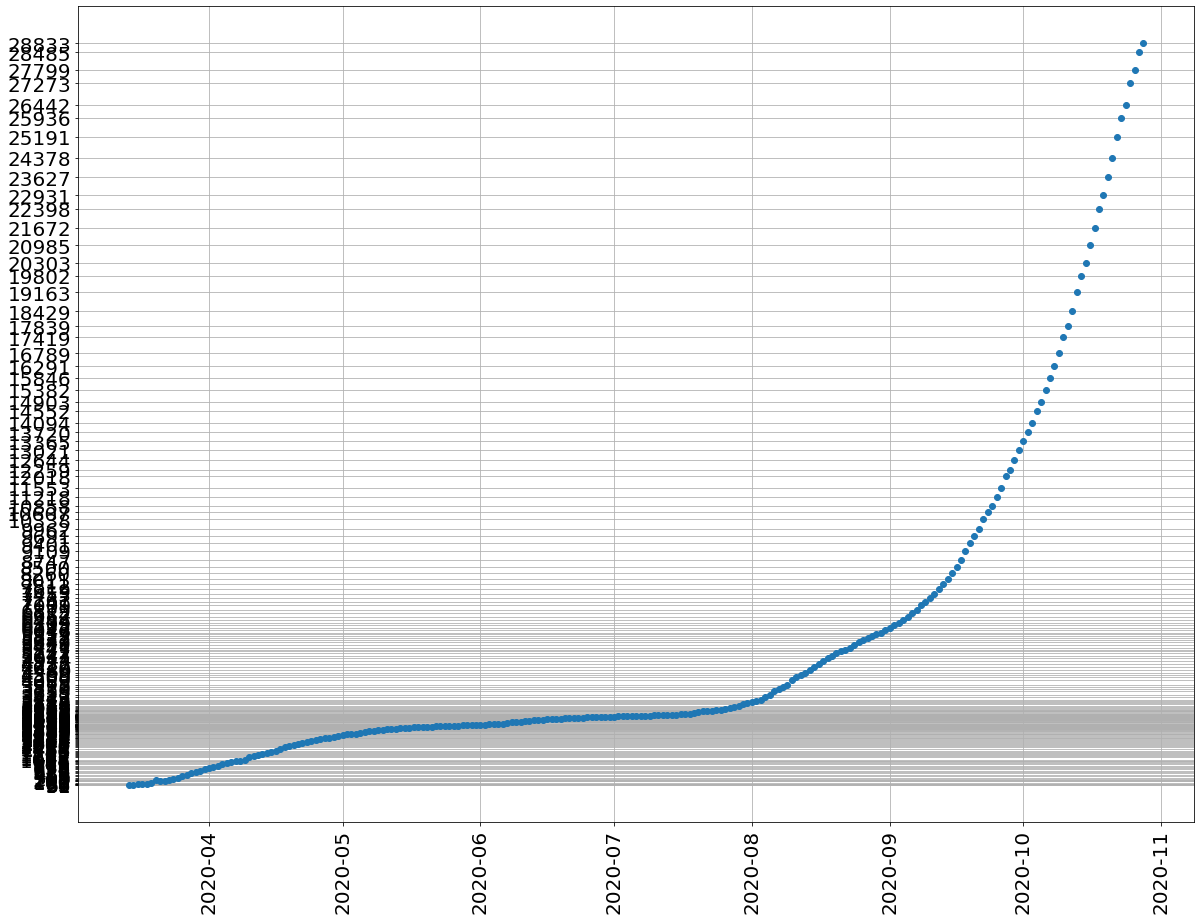

      Date_of_report  Total_reported
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
1944      2020-03-18              61
...              ...             ...
82684     2020-10-24           26442
83051     2020-10-25           27273
83418     2020-10-26           27799
83785     2020-10-27           28485
84152     2020-10-28           28833

[229 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

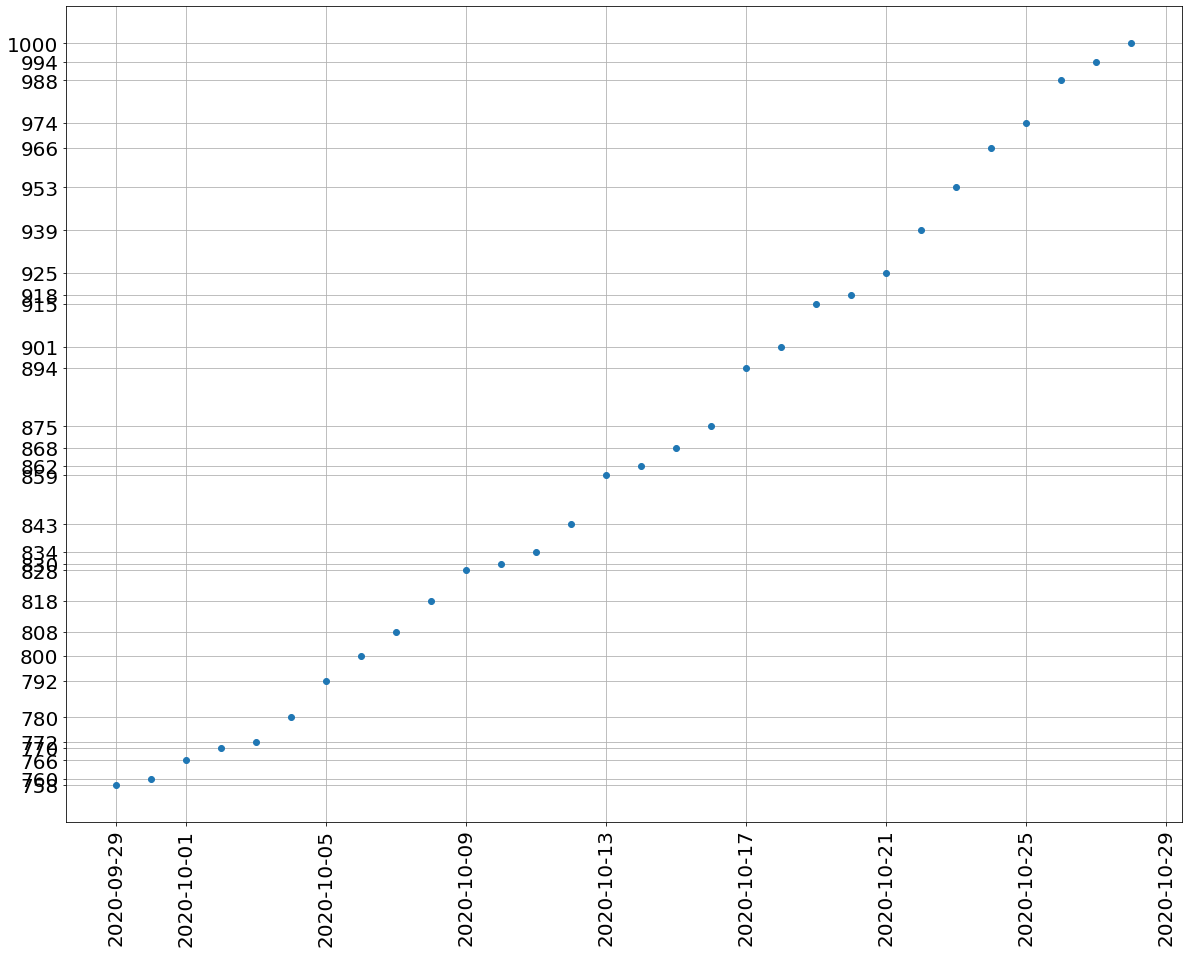

      Date_of_report  Hospital_admission
73509     2020-09-29                 758
73876     2020-09-30                 760
74243     2020-10-01                 766
74610     2020-10-02                 770
74977     2020-10-03                 772
75344     2020-10-04                 780
75711     2020-10-05                 792
76078     2020-10-06                 800
76445     2020-10-07                 808
76812     2020-10-08                 818
77179     2020-10-09                 828
77546     2020-10-10                 830
77913     2020-10-11                 834
78280     2020-10-12                 843
78647     2020-10-13                 859
79014     2020-10-14                 862
79381     2020-10-15                 868
79748     2020-10-16                 875
80115     2020-10-17                 894
80482     2020-10-18                 901
80849     2020-10-19                 915
81216     2020-10-20                 918
81583     2020-10-21                 925
81950     2020-1

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

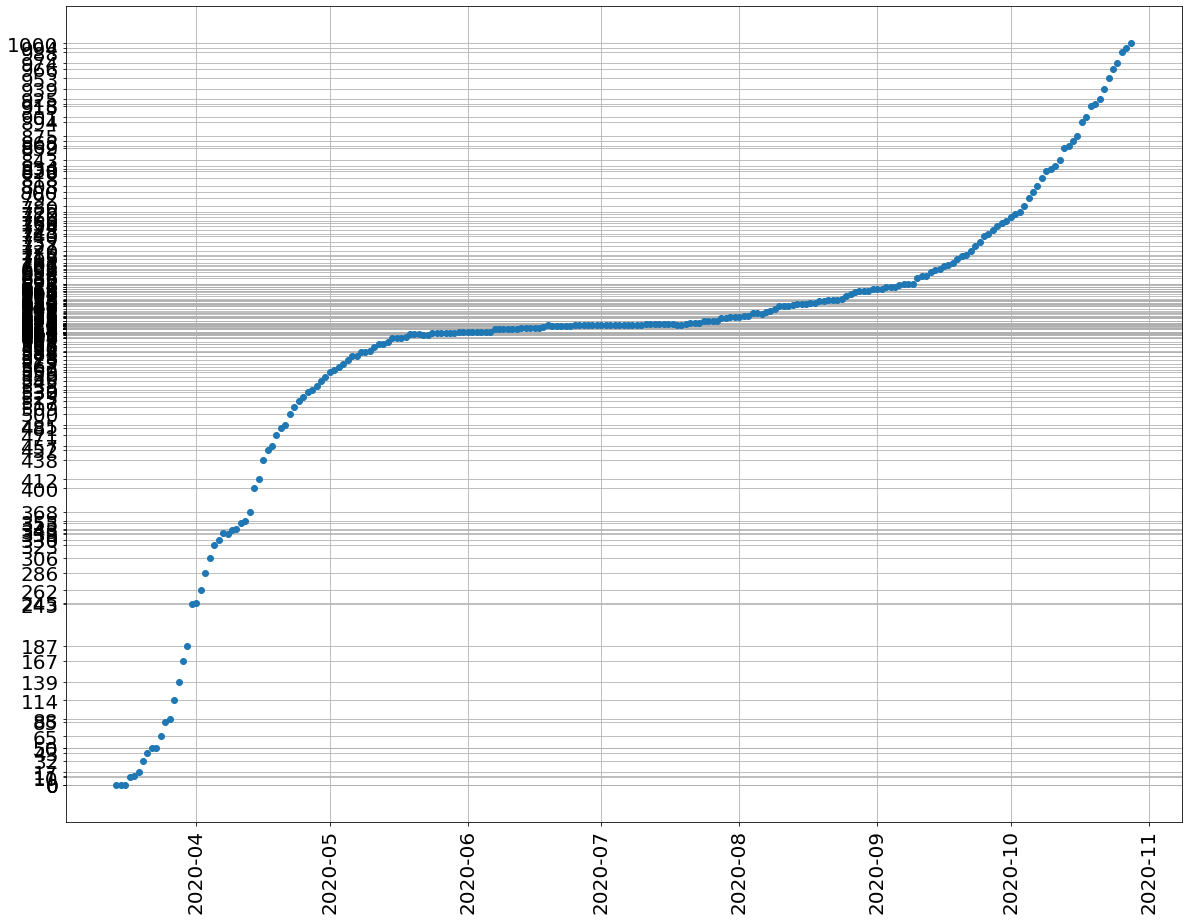

      Date_of_report  Hospital_admission
476       2020-03-14                   0
843       2020-03-15                   0
1210      2020-03-16                   0
1577      2020-03-17                  10
1944      2020-03-18                  11
...              ...                 ...
82684     2020-10-24                 966
83051     2020-10-25                 974
83418     2020-10-26                 988
83785     2020-10-27                 994
84152     2020-10-28                1000

[229 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

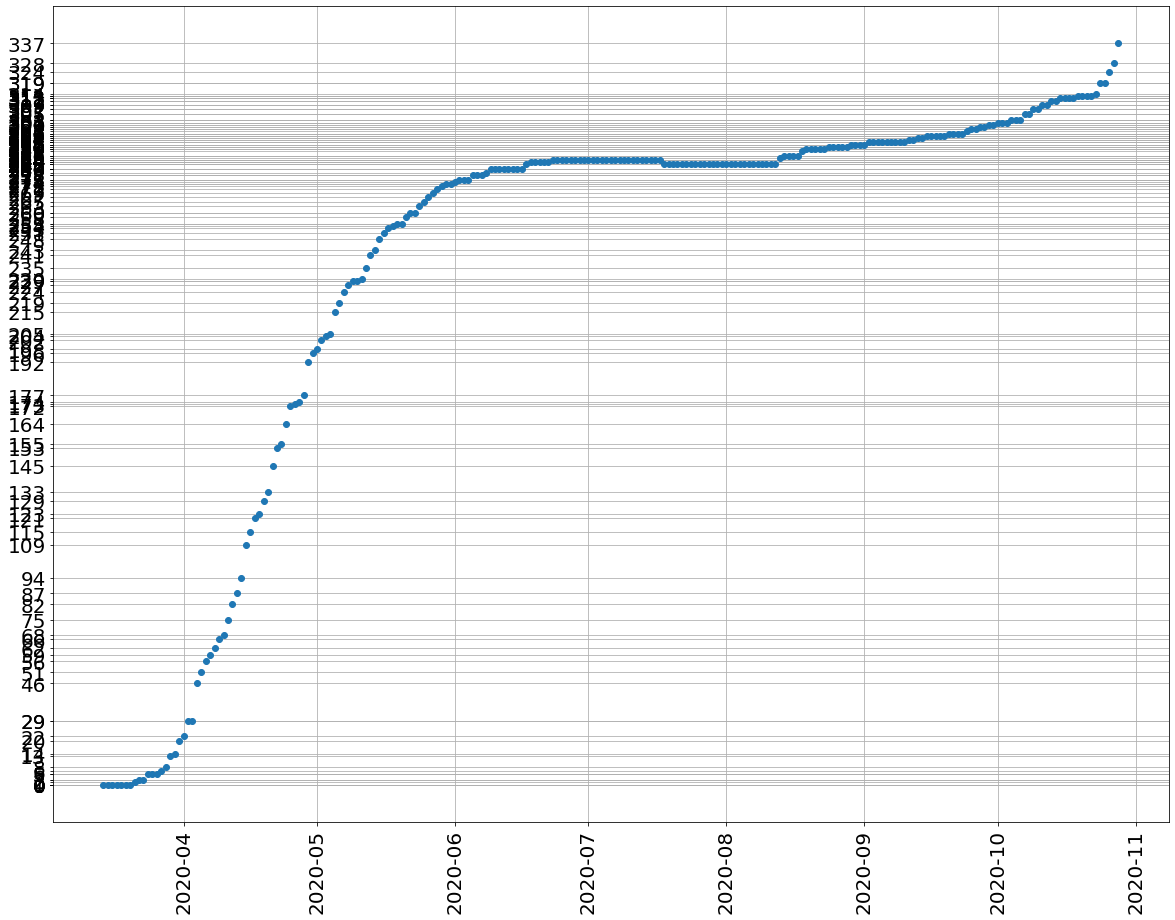

      Date_of_report  Deceased
476       2020-03-14         0
843       2020-03-15         0
1210      2020-03-16         0
1577      2020-03-17         0
1944      2020-03-18         0
...              ...       ...
82684     2020-10-24       319
83051     2020-10-25       319
83418     2020-10-26       324
83785     2020-10-27       328
84152     2020-10-28       337

[229 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")